In [1]:
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import gaussian_kde
import re

_display_plot_rcParams = {
    'figure.figsize' : [10,7],
    'figure.dpi' : 100,
    'xtick.top' : True,
    'xtick.direction' : 'in',
    'xtick.minor.visible' : True,
    'ytick.right' : True,
    'ytick.direction' : 'in',
    'ytick.minor.visible' : True,
    'font.size' : 12,
    'mathtext.default' : 'regular',
    'font.family' : 'DejaVu Serif',
    }
matplotlib.rcParams.update(_display_plot_rcParams)

In [2]:
def read_data(files):
    data = np.zeros((len(files),8))
    for i,f in enumerate(files):
        df = pd.read_csv(f)
        
        # file is of the form dimer_d{dim}dimer{N}.csv
        dim,N = re.findall(r'\d+',f)
        dim = int(dim)
        N = int(N)
        Re2 = df['Re2'].mean()
        Rg2 = df['Rg2'].mean()
        Rm2 = df['Rm2'].mean()
        acceptance_frac = df['acceptance'].mean()
        Re2_std = df['Re2'].std()
        Rg2_std = df['Rg2'].std()
        Rm2_std = df['Rm2'].std()
        
        data[i] = [N,Re2,Rg2,Rm2, Re2_std, Rg2_std, Rm2_std, acceptance_frac]
    return data


d2_files = sorted(glob('../data/dimers/dimer_d2*.csv'))
d3_files = sorted(glob('../data/dimers/dimer_d3*.csv'))
min_len = min(len(d2_files),len(d3_files))
d2_files = d2_files[:min_len]
d3_files = d3_files[:min_len]
d2_data = read_data(d2_files)
d3_data = read_data(d3_files)

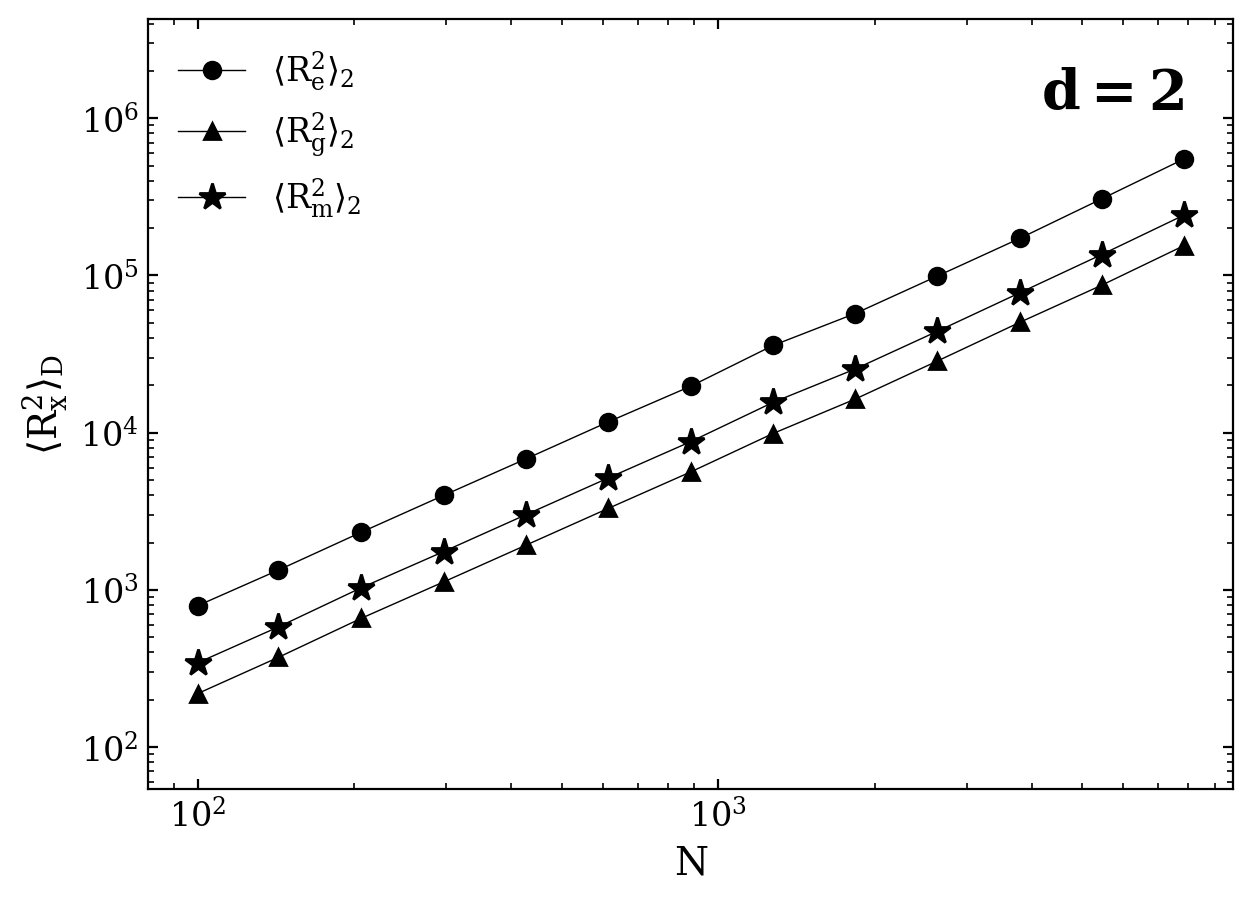

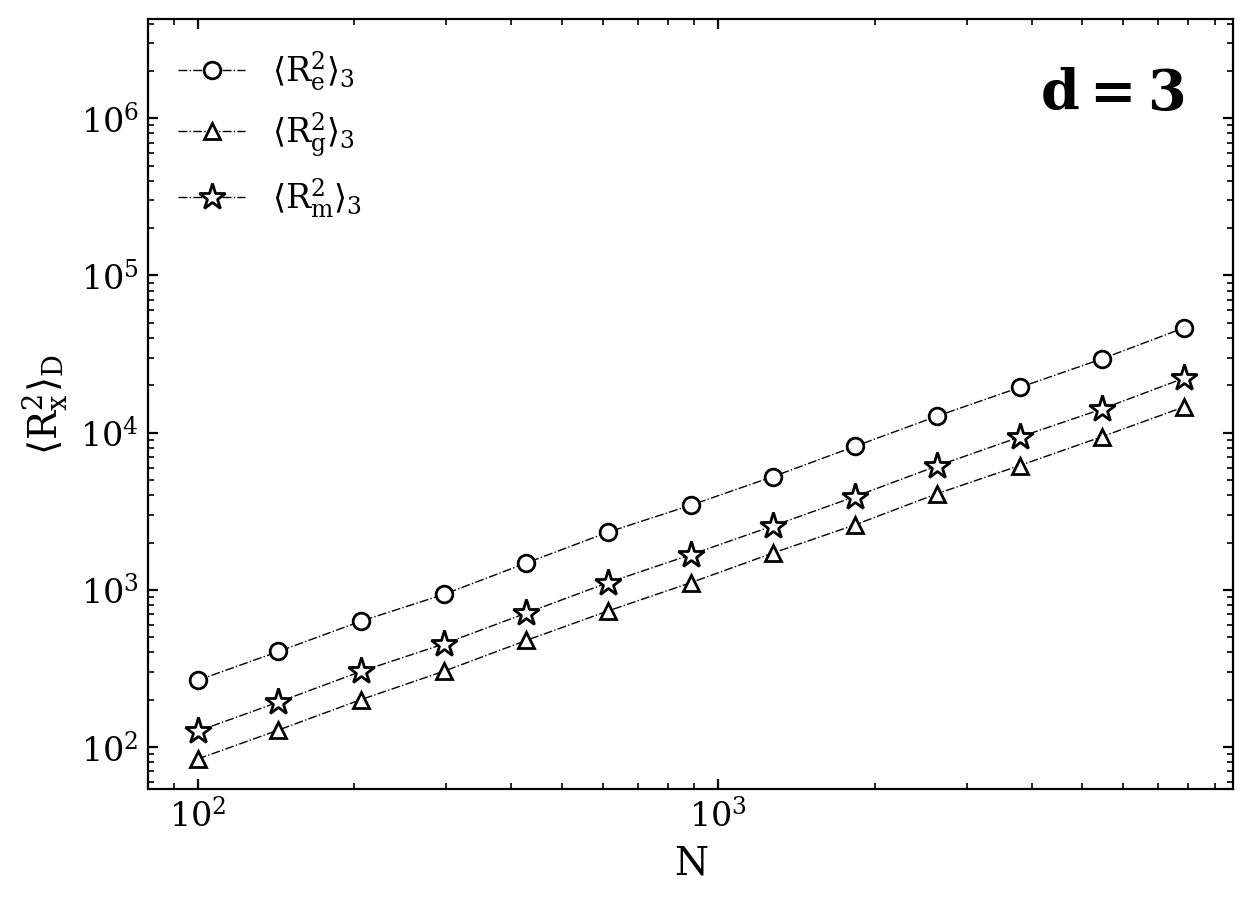

In [3]:
def darken(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    c = mc.cnames[color]
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

for i,data in enumerate([d2_data,d3_data]):
    plt.figure(figsize=(7,5),dpi=200)
    ls = ['-','-.'][i]
    D = [2,3][i]
    # colors = [['red','green','blue'],['darkred','darkgreen', 'darkblue']][i]
    colors = ['k']*3
    marker = ['o', '^', '*']
    markerfacecolor = [['k']*3,['white', 'white', 'white']][i]
    plt.plot(data[:,0],data[:,1],ls,label=f'$\\langle R_e^2 \\rangle_{{{D}}}$', color=colors[0], marker=marker[0], markerfacecolor=markerfacecolor[0], lw=0.5)
    plt.plot(data[:,0],data[:,2],ls,label=f'$\\langle R_g^2 \\rangle_{{{D}}}$', color=colors[1], marker=marker[1], markerfacecolor=markerfacecolor[1], lw=0.5)
    plt.plot(data[:,0],data[:,3],ls,label=f'$\\langle R_m^2 \\rangle_{{{D}}}$', color=colors[2], marker=marker[2], markerfacecolor=markerfacecolor[2], lw=0.5, markersize=10)
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(54.10939259283736, 5*854777.3573472024)
    plt.xlabel('N', fontsize=14)
    plt.ylabel('$\\langle R_x^2 \\rangle_D$', fontsize=14)
    plt.legend(frameon=False, fontsize=12, ncols=1, loc='upper left')
    plt.text(data[:,0].max(), plt.ylim()[1]/2, f'$d={D}$', ha='right', va='top', fontsize=20, fontweight='bold')
    plt.savefig(f'../data/figures/Rx2_{D}d.pdf', bbox_inches='tight')
    plt.show()
# plt.xlim(0,)
# plt.ylim(0,)

In [4]:
from scipy.optimize import curve_fit

def Rx2(N, D_x, nu):
    return D_x*N**(2*nu)

def estimate_vars_Rx2(data, x):
    x_to_i = {'e':1, 'g':2, 'm':3}
    N = data[:,0]
    Rx2_data = data[:,x_to_i[x]]
    popt, pcov = curve_fit(Rx2, N, Rx2_data, p0=[1,0.5])
    return popt, np.sqrt(np.diag(pcov))

def estimate_nu(dD_data):
    estimates = [estimate_vars_Rx2(dD_data, x) for x in ['e','g','m']]
    nu_estimates = np.array([[x[0][1],x[1][1]] for x in estimates])
    weights = 1/nu_estimates[:,1]**2
    weighted_mean = np.average(nu_estimates[:,0], weights=weights)
    combined_error = (1 / weights.sum()) ** 0.5
    return weighted_mean, combined_error

def estimate_Dx(data, x):
    popt, pcov = estimate_vars_Rx2(data, x)
    return popt[0], pcov[0]

In [5]:
from IPython.display import Markdown
import pandas as pd


def to_shorthand(value, uncertainty):
    """ Convert a value with uncertainty to shorthand notation. """
    if uncertainty == 0:
        raise ValueError("Uncertainty cannot be zero.")
    
    uncertainty_digits = -int(np.floor(np.log10(abs(uncertainty)))) + 1
    if uncertainty_digits < 0:
        rounded_uncertainty = round(uncertainty, -uncertainty_digits)
    else:
        rounded_uncertainty = round(uncertainty, uncertainty_digits)
    rounded_value = round(value, uncertainty_digits)
    int_uncertainty = int(rounded_uncertainty * (10 ** uncertainty_digits))
    return f"{rounded_value}({int_uncertainty})"

"""
Make a table of the form

| D | $\\nu$ | $D_e$ | $D_g$ | $D_m$ |
|---|--------|-------|-------|-------|
| 2 |        |       |       |       |
| 3 |        |       |       |       |
--------------------------------------
"""

table = pd.DataFrame(columns=['D','$\\nu$','$D_e$','$D_g$','$D_m$'])
table['D'] = [2,3]

nus = []
Des = []
Dgs = []
Dms = []
for i,data in enumerate([d2_data,d3_data]):
    nu,nu_err = estimate_nu(data)
    De, De_err = estimate_Dx(data, 'e')
    Dg, Dg_err = estimate_Dx(data, 'g')
    Dm, Dm_err = estimate_Dx(data, 'm')
    nus.append(to_shorthand(nu,nu_err))
    Des.append(to_shorthand(De,De_err))
    Dgs.append(to_shorthand(Dg,Dg_err))
    Dms.append(to_shorthand(Dm,Dm_err))
    
table['$\\nu$'] = nus
table['$D_e$'] = Des
table['$D_g$'] = Dgs
table['$D_m$'] = Dms

table.to_latex('../data/tables/results.tex', index=False, escape=False, column_format='ccccc', bold_rows=True)
Markdown(table.to_markdown(index=False))

/var/folders/w7/xwdclb5101q6zdxfxf7910pr0000gp/T/ipykernel_91683/3778789313.py:51: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table.to_latex('../data/tables/results.tex', index=False, escape=False, column_format='ccccc', bold_rows=True)


|   D | $\nu$      | $D_e$     | $D_g$     | $D_m$     |
|----:|:-----------|:----------|:----------|:----------|
|   2 | 0.7794(23) | 0.402(38) | 0.142(10) | 0.206(14) |
|   3 | 0.5916(16) | 1.029(65) | 0.375(13) | 0.522(33) |

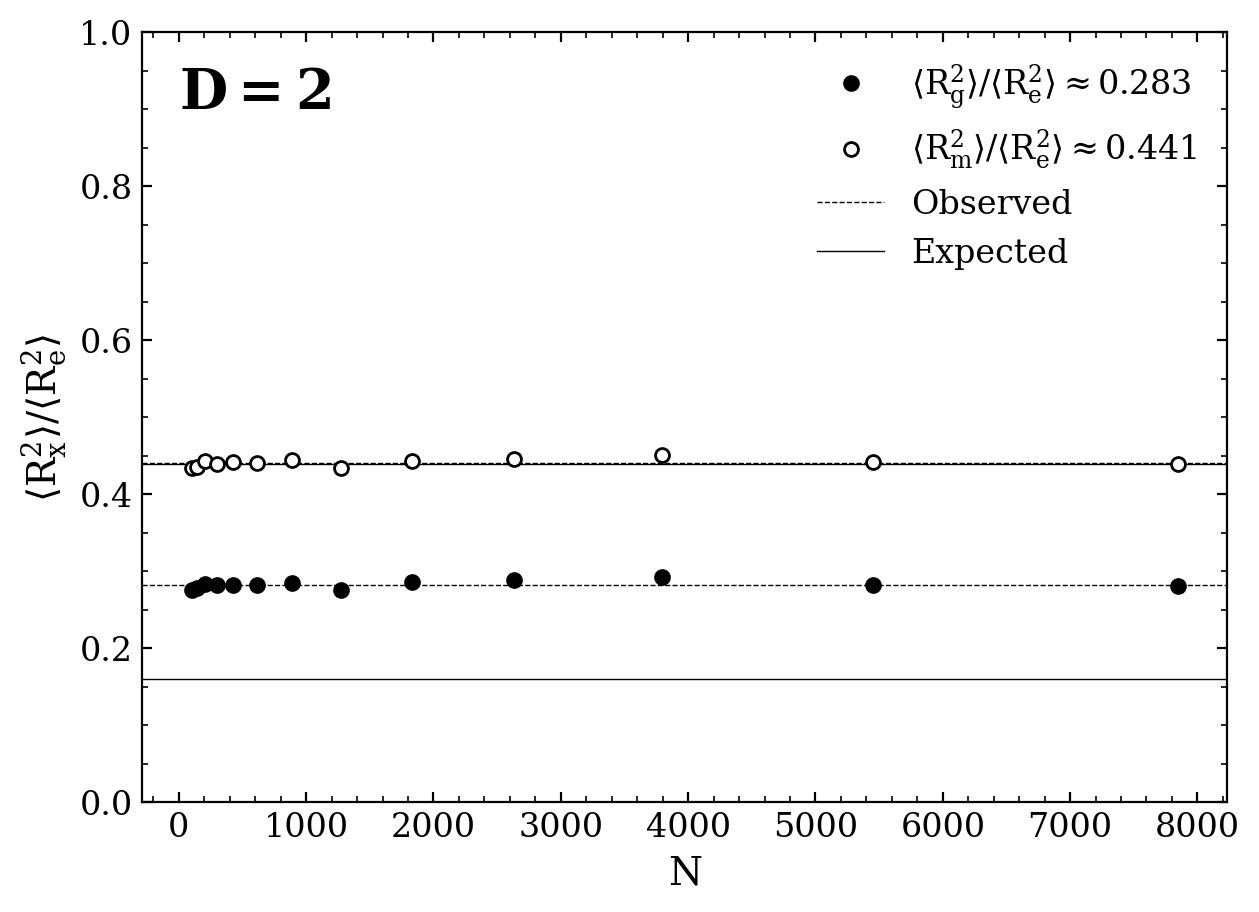

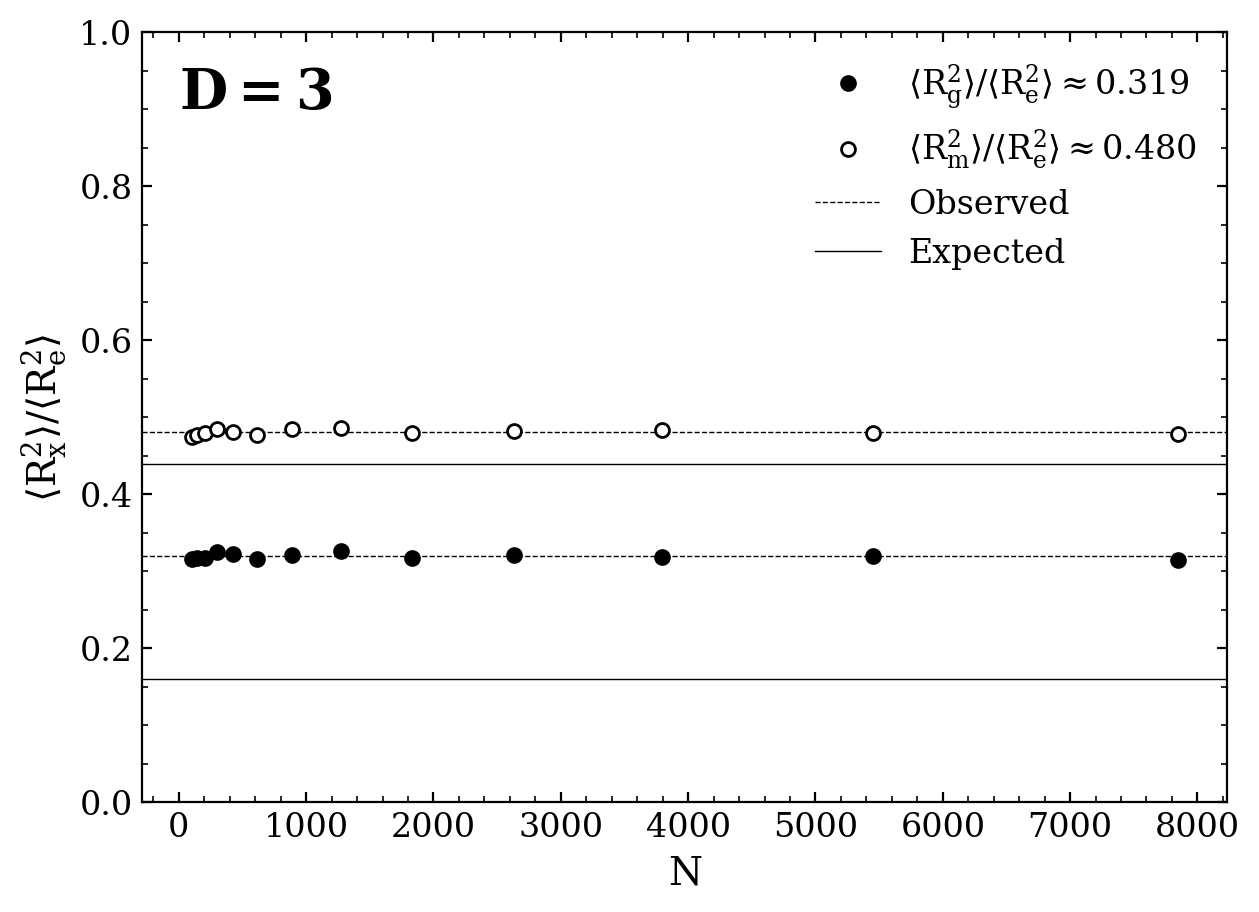

In [6]:
for d,data in zip([2,3],[d2_data,d3_data]):
    Rg2_over_Re2 = data[:,2]/data[:,1]
    # N Re2 Rg2 Rm2 Re2_std Rg2_std Rm2_std
    Rg2_over_Re2_err = Rg2_over_Re2 * np.sqrt((data[:,5]/data[:,2])**2 + (data[:,4]/data[:,1])**2)
    Rm2_over_Re2 = data[:,3]/data[:,1]
    Rm2_over_Re2_err = Rm2_over_Re2 * np.sqrt((data[:,6]/data[:,3])**2 + (data[:,4]/data[:,1])**2)

    plt.figure(figsize=(7,5),dpi=200)
    mean = Rg2_over_Re2.mean()
    plt.plot(data[:,0],Rg2_over_Re2,'o',markersize=5, label=f'$\\langle R_g^2\\rangle/\\langle R_e^2\\rangle\\approx{mean:.3f}$', c='k')
    plt.axhline(mean, ls='--', c='k', zorder=-999, lw=.5)
    mean = Rm2_over_Re2.mean()
    plt.plot(data[:,0],Rm2_over_Re2,'o',markersize=5, label=f'$\\langle R_m^2\\rangle/\\langle R_e^2\\rangle\\approx{mean:.3f}$', c='k', mfc='white')
    plt.axhline(mean, ls='--', c='k', zorder=-999, lw=.5, label='Observed')

    # expected values
    plt.axhline(0.43961, ls='-', c='k', zorder=-999, lw=.5, label='Expected')
    plt.axhline(0.1599, ls='-', c='k', zorder=-999, lw=.5)

    plt.legend(frameon=False)
    plt.xlabel('N', fontsize=14)
    plt.ylabel('$\\langle R_x^2\\rangle/\\langle R_e^2\\rangle$', fontsize=14)
    plt.text(0, 0.9, f'$D={d}$', fontsize=20, fontweight='bold')
    plt.ylim(0, 1.0)
    plt.savefig(f'../data/figures/Rx2_over_Re2_{d}d.pdf', bbox_inches='tight')
    plt.show()

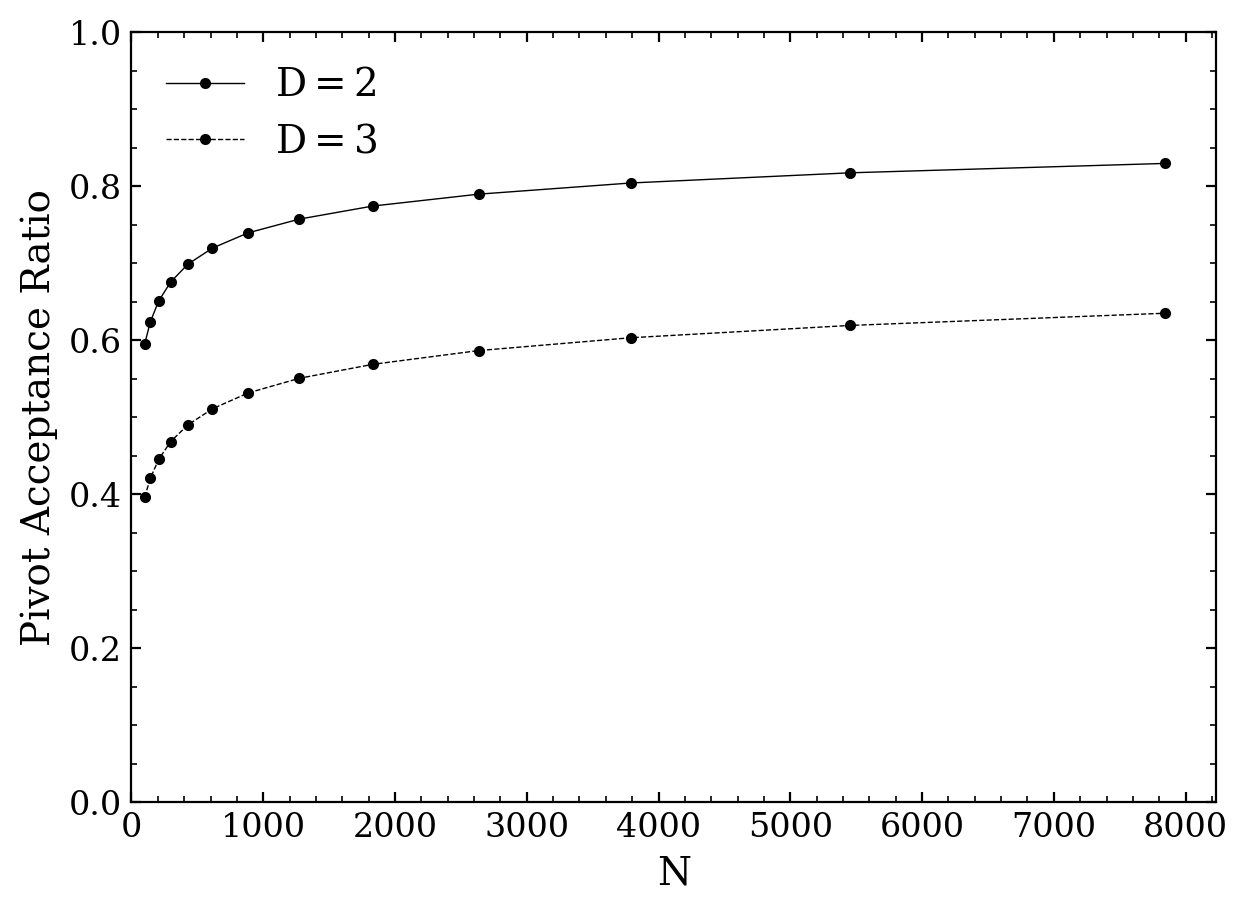

In [7]:
plt.figure(figsize=(7,5),dpi=200)
plt.plot(d2_data[:,0], d2_data[:,-1], '-o', c='k', label='$D=2$', markersize=3, lw=0.5)
plt.plot(d3_data[:,0], d3_data[:,-1], '--o', c='k', label='$D=3$', markersize=3, lw=0.5)
plt.ylim(0,1)
plt.xlim(0,)
plt.legend(frameon=False, loc='upper left', fontsize=14)
plt.xlabel('N', fontsize=14)
plt.ylabel('Pivot Acceptance Ratio', fontsize=14)
plt.savefig('../data/figures/acceptance.pdf', bbox_inches='tight')
plt.show()

In [8]:
table = pd.DataFrame(columns=['D', '$\\nu$', '$\\nu_e$', '$\\nu_g$', '$\\nu_m$', '$D_e$', '$D_g$', '$D_m$'])
table['D']= [2,3]


nus = []
nu_es = []
nu_gs = []
nu_ms = []
Des = []
Dgs = []
Dms = []
for i,data in enumerate([d2_data,d3_data]):
    (De,nu_e), (De_err,nu_e_err) = estimate_vars_Rx2(data, 'e')
    (Dg,nu_g), (Dg_err,nu_g_err) = estimate_vars_Rx2(data, 'g')
    (Dm,nu_m), (Dm_err,nu_m_err) = estimate_vars_Rx2(data, 'm')
    
    nu, nu_err = estimate_nu(data)
    nus.append(to_shorthand(nu, nu_err))
    nu_es.append(to_shorthand(nu_e, nu_e_err))
    nu_gs.append(to_shorthand(nu_g, nu_g_err))
    nu_ms.append(to_shorthand(nu_m, nu_m_err))
    Des.append(to_shorthand(De, De_err))
    Dgs.append(to_shorthand(Dg, Dg_err))
    Dms.append(to_shorthand(Dm, Dm_err))
    
table['$\\nu$'] = nus
table['$\\nu_e$'] = nu_es
table['$\\nu_g$'] = nu_gs
table['$\\nu_m$'] = nu_ms
table['$D_e$'] = Des
table['$D_g$'] = Dgs
table['$D_m$'] = Dms

table.to_latex('../data/tables/results_individual.tex', index=False, escape=False, column_format='ccccc', bold_rows=True)
Markdown(table.to_markdown(index=False))


/var/folders/w7/xwdclb5101q6zdxfxf7910pr0000gp/T/ipykernel_91683/3032030149.py:34: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table.to_latex('../data/tables/results_individual.tex', index=False, escape=False, column_format='ccccc', bold_rows=True)


|   D | $\nu$      | $\nu_e$    | $\nu_g$    | $\nu_m$    | $D_e$     | $D_g$     | $D_m$     |
|----:|:-----------|:-----------|:-----------|:-----------|:----------|:----------|:----------|
|   2 | 0.7794(23) | 0.7877(53) | 0.775(40)  | 0.7791(37) | 0.402(38) | 0.142(10) | 0.206(14) |
|   3 | 0.5916(16) | 0.5973(36) | 0.5891(20) | 0.594(36)  | 1.029(65) | 0.375(13) | 0.522(33) |